In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import make_column_selector
from imblearn.pipeline import Pipeline

***Hasil histogram star***

Kolom tersedia:
 Index(['title', 'url', 'stars', 'name', 'reviewUrl', 'text'], dtype='object')


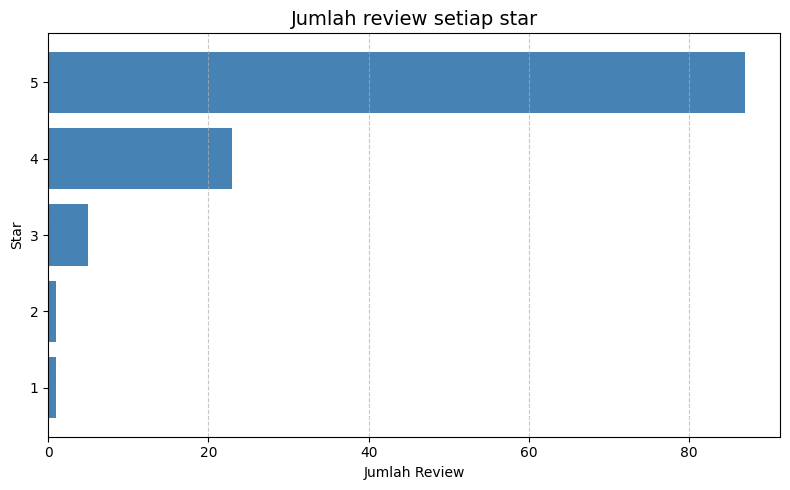

Jumlah review tiap star:
stars
1     1
2     1
3     5
4    23
5    87
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ===========================================================
# 📂 Load Dataset (Coba Beberapa Separator)
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"

# Coba baca otomatis separator
try:
    data = pd.read_csv(url)
except pd.errors.ParserError:
    try:
        data = pd.read_csv(url, sep=';')
    except pd.errors.ParserError:
        data = pd.read_csv(url, sep='\t')

# ===========================================================
# 🔍 Cek Kolom
# ===========================================================
print("Kolom tersedia:\n", data.columns)

# ===========================================================
# 📊 Tentukan Kolom Rating
# ===========================================================
# Cari kolom yang ada kata 'star' atau 'rating'
kolom_star = None
for c in data.columns:
    if 'star' in c.lower() or 'rating' in c.lower():
        kolom_star = c
        break

if kolom_star is None:
    raise ValueError("Kolom berisi rating/star tidak ditemukan. Cek data.columns dulu.")

# ===========================================================
# 📊 Hitung dan Visualisasi
# ===========================================================
jumlah_star = data[kolom_star].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.barh(jumlah_star.index.astype(str), jumlah_star.values, color='steelblue')
plt.title('Jumlah review setiap star', fontsize=14)
plt.xlabel('Jumlah Review')
plt.ylabel('Star')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Jumlah review tiap star:")
print(jumlah_star)

***Persentase Hanya Rating + Rating Saja***

📘 Jumlah total data: 117
📋 Kolom tersedia: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text'] 

✅ Kolom teks ulasan yang digunakan : text
✅ Kolom rating yang digunakan      : stars

📊 Statistik Review & Rating:
Total data                        : 117
Dengan review + rating             : 52 (44.44%)
Hanya memberi rating (tanpa review): 65 (55.56%)



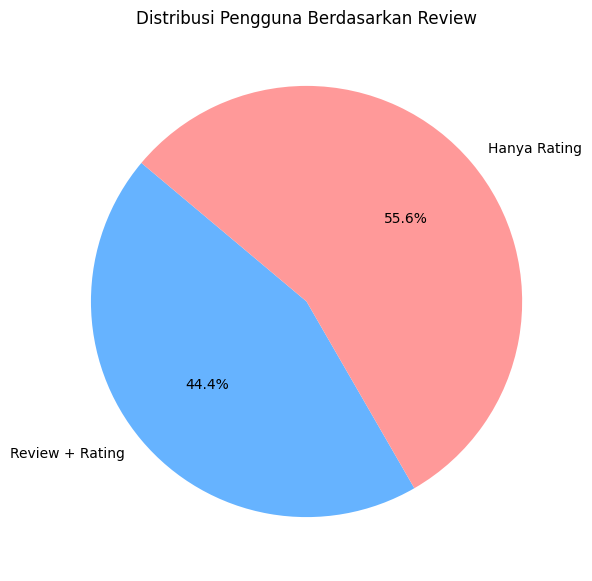

📝 Contoh data pengguna yang hanya memberi rating tanpa review:
   stars text
1      5  NaN
2      5  NaN
3      5  NaN
7      5  NaN
9      5  NaN 

📝 Contoh data pengguna yang memberi review + rating:
   stars                                               text
0      5                                            ממש יפה
4      4  Tillya Sheikh Mosque, Friday Mosque.\n\nThe Ti...
5      4                          Interessante Fotolocation
6      5                                      Goʻzal masjid
8      3                                 Bad path to get in 



In [ ]:
# =====================================
# 🎯 Analisis Review & Rating (AUTO-FIX)
# =====================================

import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 1️⃣ Load Dataset ----------------
url = 'https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv'

# Deteksi otomatis delimiter (koma atau titik koma)
with open('/tmp/tillya.csv', 'w', encoding='utf-8') as f:
    import requests
    f.write(requests.get(url).text)

with open('/tmp/tillya.csv', encoding='utf-8') as f:
    sample = f.readline()
    sep = ';' if ';' in sample else ','

# Baca dataset dengan delimiter yang benar
data = pd.read_csv('/tmp/tillya.csv', sep=sep, engine='python', on_bad_lines='skip')

# Bersihkan nama kolom
data.columns = data.columns.str.replace('"', '').str.strip()
print("📘 Jumlah total data:", len(data))
print("📋 Kolom tersedia:", list(data.columns), "\n")

# ---------------- 2️⃣ Deteksi Kolom ----------------
# Kolom teks
possible_text_cols = ['text', 'review', 'title']
text_col = next((col for col in possible_text_cols if col in data.columns), None)
if text_col is None:
    raise KeyError("❌ Tidak ditemukan kolom teks ulasan (text/review/title).")

# Kolom rating
possible_rating_cols = ['stars', 'rating']
rating_col = next((col for col in possible_rating_cols if col in data.columns), None)
if rating_col is None:
    raise KeyError("❌ Tidak ditemukan kolom rating (stars/rating).")

print(f"✅ Kolom teks ulasan yang digunakan : {text_col}")
print(f"✅ Kolom rating yang digunakan      : {rating_col}\n")

# ---------------- 3️⃣ Analisis Ada/Tidaknya Review ----------------
data['Ada_Review'] = data[text_col].apply(lambda x: bool(str(x).strip()) and str(x).lower() != 'nan')

total_data = len(data)
dengan_review = data['Ada_Review'].sum()
tanpa_review = total_data - dengan_review

persen_dengan = (dengan_review / total_data) * 100
persen_tanpa = (tanpa_review / total_data) * 100

print("📊 Statistik Review & Rating:")
print(f"Total data                        : {total_data}")
print(f"Dengan review + rating             : {dengan_review} ({persen_dengan:.2f}%)")
print(f"Hanya memberi rating (tanpa review): {tanpa_review} ({persen_tanpa:.2f}%)\n")

# ---------------- 4️⃣ Visualisasi Pie Chart ----------------
plt.figure(figsize=(7, 7))
plt.pie([dengan_review, tanpa_review],
        labels=['Review + Rating', 'Hanya Rating'],
        autopct='%1.1f%%', startangle=140,
        colors=['#66b3ff', '#ff9999'])
plt.title("Distribusi Pengguna Berdasarkan Review")
plt.show()

# ---------------- 5️⃣ Contoh Data ----------------
print("📝 Contoh data pengguna yang hanya memberi rating tanpa review:")
print(data.loc[~data['Ada_Review'], [rating_col, text_col]].head(5), "\n")

print("📝 Contoh data pengguna yang memberi review + rating:")
print(data.loc[data['Ada_Review'], [rating_col, text_col]].head(5), "\n")


***Pre-Processing***

In [ ]:
import pandas as pd

data_csv = 'https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv'

data = pd.read_csv(data_csv, on_bad_lines='skip')  # lewati baris yang rusak
data.head()

,title;url;stars;name;reviewUrl;text
0,Tillya Sheikh Mosque;https://www.google.com/ma...
1,Tillya Sheikh Mosque;https://www.google.com/ma...
2,Tillya Sheikh Mosque;https://www.google.com/ma...
3,Tillya Sheikh Mosque;https://www.google.com/ma...
4,Tillya Sheikh Mosque;https://www.google.com/ma...


In [ ]:
# ===========================================================
# 📚 Import Library
# ===========================================================
import pandas as pd

# ===========================================================
# 📂 Membaca Dataset dengan Penanganan Otomatis
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"

# Baca dataset dengan pemisah titik koma (;) dan abaikan baris rusak
df = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

# Bersihkan nama kolom dari spasi dan tanda kutip
df.columns = df.columns.str.strip().str.replace('"', '')

print("✅ Dataset berhasil dimuat!")
print("📘 Jumlah data:", len(df))
print("📋 Kolom tersedia:", list(df.columns), "\n")

# ===========================================================
# 🧹 Menghapus Kolom yang Tidak Diperlukan
# ===========================================================
df_cleaned = df.drop(columns=['name', 'reviewUrl', 'url', 'stars'], errors='ignore')

# ===========================================================
# 🧾 Menampilkan Hasil dalam Bentuk Tabel
# ===========================================================
print("✅ Kolom setelah dihapus:", list(df_cleaned.columns))
print("\n📊 Data hasil pembersihan:")
display(df_cleaned.head(10))


✅ Dataset berhasil dimuat!
📘 Jumlah data: 117
📋 Kolom tersedia: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text'] 

✅ Kolom setelah dihapus: ['title', 'text']

📊 Data hasil pembersihan:


,title,text
0,Tillya Sheikh Mosque,ממש יפה
1,Tillya Sheikh Mosque,NaN
2,Tillya Sheikh Mosque,NaN
3,Tillya Sheikh Mosque,NaN
4,Tillya Sheikh Mosque,"Tillya Sheikh Mosque, Friday Mosque.\n\nThe Ti..."
5,Tillya Sheikh Mosque,Interessante Fotolocation
6,Tillya Sheikh Mosque,Goʻzal masjid
7,Tillya Sheikh Mosque,NaN
8,Tillya Sheikh Mosque,Bad path to get in
9,Tillya Sheikh Mosque,NaN


***Cleaning Data (Empty Review)***

In [ ]:
# ===========================================================
# 📚 Import Library
# ===========================================================
import pandas as pd

# ===========================================================
# 📂 Membaca Dataset
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"

df = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

# Bersihkan nama kolom
df.columns = df.columns.str.strip().str.replace('"', '')

print("📋 Kolom sebelum pemrosesan:", list(df.columns))

# ===========================================================
# ✂️ Ambil hanya kolom title dan text
# ===========================================================
df_selected = df[['title', 'text']]  # hanya ambil 2 kolom

# ===========================================================
# 🧹 Menghapus baris yang text-nya NaN
# ===========================================================
df_cleaned = df_selected.dropna(subset=['text'])

print("📘 Jumlah data setelah menghapus text NaN:", len(df_cleaned))

# ===========================================================
# 📊 Tampilkan hasil
# ===========================================================
display(df_cleaned.head(10))


📋 Kolom sebelum pemrosesan: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text']
📘 Jumlah data setelah menghapus text NaN: 52


,title,text
0,Tillya Sheikh Mosque,ממש יפה
4,Tillya Sheikh Mosque,"Tillya Sheikh Mosque, Friday Mosque.\n\nThe Ti..."
5,Tillya Sheikh Mosque,Interessante Fotolocation
6,Tillya Sheikh Mosque,Goʻzal masjid
8,Tillya Sheikh Mosque,Bad path to get in
10,Tillya Sheikh Mosque,Very impressive monument in typical Samarkand ...
11,Tillya Sheikh Mosque,Beautiful mosque 🕌.
16,Tillya Sheikh Mosque,Tillya Sheikh Mosque is a part of a wider Hazr...
17,Tillya Sheikh Mosque,Több szép muszlim épület. Ima időt ki kell vár...
18,Tillya Sheikh Mosque,بني المجمع بالقرب من قبر إمام مدينة طشقند، وهو...


***Translate Review Bhs Inggris***

In [ ]:
# ===========================================================
# 📚 Install dan Import Library
# ===========================================================
!pip install googletrans==4.0.0-rc1 --quiet
!pip install tqdm --quiet

import pandas as pd
from googletrans import Translator
from tqdm import tqdm
from IPython.display import display

# ===========================================================
# 1️⃣ Baca Dataset
# ===========================================================
url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8', dtype=str)

# ===========================================================
# 2️⃣ Inisialisasi Translator
# ===========================================================
translator = Translator()

# ===========================================================
# 3️⃣ Fungsi Translate Aman
# ===========================================================
def translate_safe(text):
    try:
        if pd.isna(text) or text.strip() == "":
            return None
        return translator.translate(text, dest='en').text
    except:
        return None

# ===========================================================
# 4️⃣ Translate Kolom title & text dengan Progress Bar
# ===========================================================
tqdm.pandas()
df['title_en'] = df['title'].progress_apply(translate_safe)
if 'text' in df.columns:
    df['text_en'] = df['text'].progress_apply(translate_safe)

# ===========================================================
# 5️⃣ Hapus Baris Kosong
# ===========================================================
df_clean = df.dropna(subset=['title_en', 'text_en'])

# ===========================================================
# 6️⃣ Tampilkan Tabel Bersih
# ===========================================================
display(df_clean[['title_en', 'text_en']])

# ===========================================================
# 7️⃣ Simpan ke CSV jika diperlukan
# ===========================================================
df_clean[['title_en', 'text_en']].to_csv("kalon_mosque_reviews_en_clean.csv", index=False)
print("✅ Hasil translate tersimpan di 'shahizinda_mosque_reviews_en_clean.csv'")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai 2.8.1 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.13.3 which is incompatible.
google-genai 1.52.0 requires httpx<1.0.0,>=0.2

100%|██████████| 117/117 [00:29<00:00,  3.92it/s]


,title_en,text_en
0,Tillya Sheikh Mosque,really beautiful
4,Tillya Sheikh Mosque,"Tillya Sheikh Mosque, Friday Mosque.\n\nThe Ti..."
5,Tillya Sheikh Mosque,Interessante Fotolocation
6,Tillya Sheikh Mosque,Go'zal mosque
8,Tillya Sheikh Mosque,Bad path to get in
10,Tillya Sheikh Mosque,Very impressive monument in typical Samarkand ...
11,Tillya Sheikh Mosque,Beautiful mosque 🕌.
16,Tillya Sheikh Mosque,Tillya Sheikh Mosque is a part of a wider Hazr...
17,Tillya Sheikh Mosque,Several beautiful Muslim buildings.You have to...
18,Tillya Sheikh Mosque,The complex was built near the grave of the Im...


✅ Hasil translate tersimpan di 'shahizinda_mosque_reviews_en_clean.csv'


***Labelling***

In [6]:
import pandas as pd

# ==============================
# Load Dataset (SEMUA DATA TILLYA)
# ==============================

url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"
data = pd.read_csv(url, sep=';', encoding='utf-8')

print("Jumlah data awal:", len(data))

# ==============================
# Data Cleaning
# ==============================

# Cek kolom dataset
print("\nKolom dataset:")
print(data.columns)

# Hapus data kosong pada kolom penting
data = data.dropna(subset=['text', 'stars'])

# Pastikan stars bertipe numerik
data['stars'] = pd.to_numeric(data['stars'], errors='coerce')
data = data.dropna(subset=['stars'])

print("Jumlah data setelah cleaning:", len(data))

# ==============================
# Label Sentimen (Rule-Based)
# ==============================

def label_sentiment(stars):
    if stars >= 4:
        return 2   # Positif
    elif stars == 3:
        return 1   # Netral
    else:
        return 0   # Negatif

data['label'] = data['stars'].apply(label_sentiment)

# Mapping label ke teks sentimen
label_map = {
    2: 'Positif',
    1: 'Netral',
    0: 'Negatif'
}

data['Sentimen'] = data['label'].map(label_map)

# ==============================
# Distribusi Sentimen
# ==============================

sentiment_counts = data['Sentimen'].value_counts().reset_index()
sentiment_counts.columns = ['Sentimen', 'Jumlah Data']

print("\nDistribusi Sentimen:")
print(sentiment_counts)

# ==============================
# Contoh Hasil Labeling
# ==============================

print("\nContoh data berlabel:")
print(data[['text', 'stars', 'label', 'Sentimen']].head())

# ==============================
# Simpan Dataset Berlabel
# ==============================

output_path = "Tillya_Sentiment_Labeled.csv"
data.to_csv(output_path, index=False, encoding='utf-8')

print(f"\nDataset berlabel berhasil disimpan sebagai: {output_path}")


Jumlah data awal: 117

Kolom dataset:
Index(['title', 'url', 'stars', 'name', 'reviewUrl', 'text'], dtype='object')
Jumlah data setelah cleaning: 52

Distribusi Sentimen:
  Sentimen  Jumlah Data
0  Positif           47
1   Netral            4
2  Negatif            1

Contoh data berlabel:
                                                text  stars  label Sentimen
0                                            ממש יפה      5      2  Positif
4  Tillya Sheikh Mosque, Friday Mosque.\n\nThe Ti...      4      2  Positif
5                          Interessante Fotolocation      4      2  Positif
6                                      Goʻzal masjid      5      2  Positif
8                                 Bad path to get in      3      1   Netral

Dataset berlabel berhasil disimpan sebagai: Tillya_Sentiment_Labeled.csv


***Persentase Sentimen***

📊 Ringkasan Persentase Sentimen Tillya Sheikh Mosque:
  Sentimen  Jumlah  Persentase (%)
0  Positif      47           90.38
1   Netral       4            7.69
2  Negatif       1            1.92


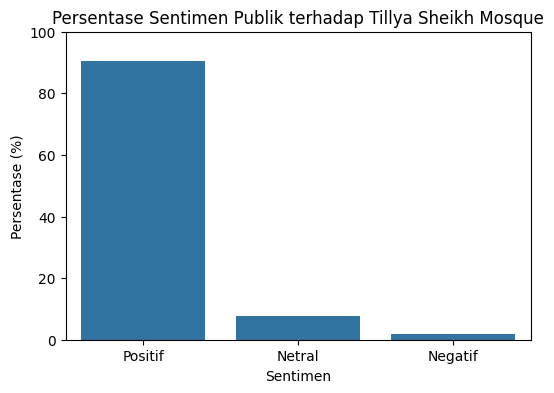

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Load Dataset Tillya
# ==============================

url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"
data = pd.read_csv(url, sep=';', encoding='utf-8')

# ==============================
# Preprocessing
# ==============================

# Hapus data kosong
data = data.dropna(subset=['text', 'stars'])

# Pastikan stars bertipe numerik
data['stars'] = pd.to_numeric(data['stars'], errors='coerce')
data = data.dropna(subset=['stars'])

# ==============================
# Fungsi Labeling Sentimen
# ==============================

def label_sentiment(stars):
    if stars >= 4:
        return 'Positif'
    elif stars == 3:
        return 'Netral'
    else:
        return 'Negatif'

# Terapkan labeling
data['Sentimen'] = data['stars'].apply(label_sentiment)

# ==============================
# Hitung Persentase Sentimen
# ==============================

# Hitung jumlah tiap sentimen
sentiment_counts = data['Sentimen'].value_counts()

# Hitung persentase
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

# Ringkasan
sentiment_summary = pd.DataFrame({
    'Sentimen': sentiment_counts.index,
    'Jumlah': sentiment_counts.values,
    'Persentase (%)': sentiment_percentages.values.round(2)
})

print("📊 Ringkasan Persentase Sentimen Tillya Sheikh Mosque:")
print(sentiment_summary)

# ==============================
# Visualisasi Bar Chart
# ==============================

plt.figure(figsize=(6,4))
sns.barplot(
    x=sentiment_summary['Sentimen'],
    y=sentiment_summary['Persentase (%)']
)

plt.ylabel("Persentase (%)")
plt.xlabel("Sentimen")
plt.title("Persentase Sentimen Publik terhadap Tillya Sheikh Mosque")
plt.ylim(0, 100)
plt.show()


***Model TourQual XLM-Roberta***

Jumlah total review: 52


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu

Menganalisis dimensi TOURQUAL: 100%|██████████| 52/52 [05:12<00:00,  6.02s/it]


📋 Tabel Distribusi Dimensi TOURQUAL:
          Dimensi  Jumlah Review
    Accessibility              0
      Environment              2
Technical Quality              8
    Human Element              9
       Experience             19
           Safety              9
      UnDimension              5


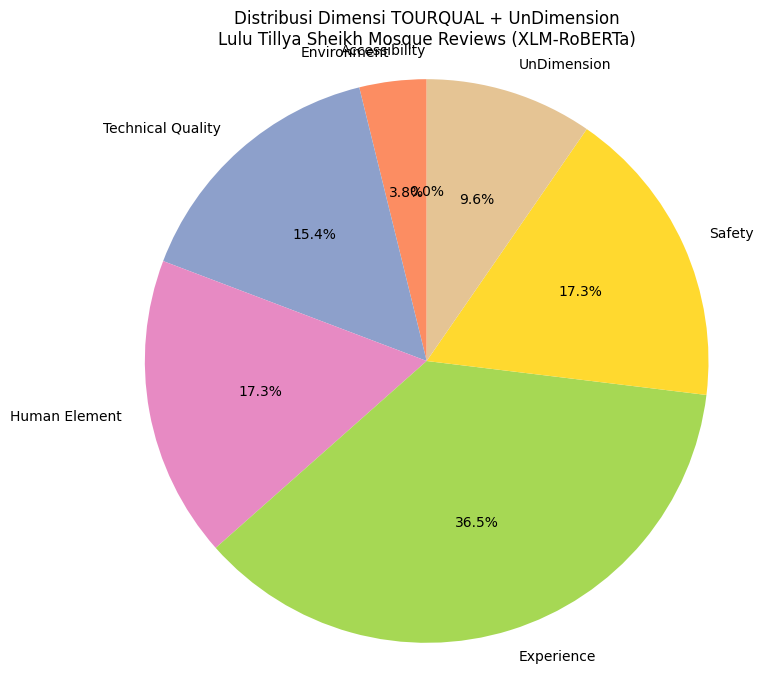

In [8]:
# ===========================================================
# 📊 Distribusi Dimensi TOURQUAL + UnDimension
# (Lulu Tillya Sheikh Mosque Reviews | XLM-RoBERTa Zero-Shot)
# ===========================================================

!pip install transformers torch pandas seaborn matplotlib tqdm --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline

# ==============================
# 1️⃣ Load Dataset Tillya
# ==============================

url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8')

# Standarisasi nama kolom
df.columns = [c.strip().lower() for c in df.columns]

# Pastikan kolom teks
text_col = 'text'
df = df.dropna(subset=[text_col]).reset_index(drop=True)
df[text_col] = df[text_col].astype(str)

print("Jumlah total review:", len(df))

# ==============================
# 2️⃣ Definisi Dimensi TOURQUAL
# ==============================

dimensions = [
    "Accessibility",
    "Environment",
    "Technical Quality",
    "Human Element",
    "Experience",
    "Safety"
]

candidate_labels = dimensions + ["UnDimension"]

# ==============================
# 3️⃣ Load Model XLM-RoBERTa
# ==============================

classifier = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli"
)

# ==============================
# 4️⃣ Klasifikasi Dimensi TOURQUAL
# ==============================

tqdm.pandas(desc="Menganalisis dimensi TOURQUAL")

def classify_dimension(text):
    result = classifier(
        text,
        candidate_labels=candidate_labels,
        hypothesis_template="This review is mainly about {}."
    )
    return result["labels"][0]

df["Dimension"] = df[text_col].progress_apply(classify_dimension)

# ==============================
# 5️⃣ Distribusi Dimensi (TABEL)
# ==============================

dimension_counts = df["Dimension"].value_counts().reindex(candidate_labels, fill_value=0)

summary_table = pd.DataFrame({
    "Dimensi": dimension_counts.index,
    "Jumlah Review": dimension_counts.values
})

print("\n📋 Tabel Distribusi Dimensi TOURQUAL:")
print(summary_table.to_string(index=False))

# ==============================
# 6️⃣ Visualisasi Pie Chart
# ==============================

plt.figure(figsize=(8,8))
plt.pie(
    dimension_counts,
    labels=dimension_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2", len(dimension_counts))
)
plt.title(
    "Distribusi Dimensi TOURQUAL + UnDimension\n"
    "Lulu Tillya Sheikh Mosque Reviews (XLM-RoBERTa)",
    fontsize=12
)
plt.axis("equal")
plt.show()


***Evaluasi***

Jumlah data evaluasi: 52

=== HASIL EVALUASI MODEL – LULU TILLYA SHEIKH MOSQUE ===
Akurasi  : 1.000
Presisi  : 1.000
Recall   : 1.000
F1-Score : 1.000


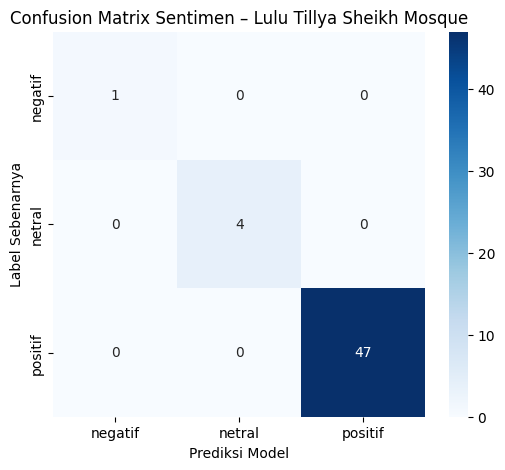

In [9]:
# ===========================================================
# 📊 Evaluasi Akurasi, Presisi, Recall, F1, Confusion Matrix
# Dataset: Lulu Tillya Sheikh Mosque (UZBEK)
# Ground Truth: Rating Stars
# ===========================================================

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1️⃣ Load Dataset Tillya
# ==============================

url = "https://raw.githubusercontent.com/byunlry-dev/klasifikasi/refs/heads/main/Lulu_Tillya%20Sheikh%20Mosque_UZBEK.csv"
df = pd.read_csv(url, sep=';', encoding='utf-8')

# Bersihkan data
df = df.dropna(subset=['text', 'stars']).reset_index(drop=True)
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')
df = df.dropna(subset=['stars'])

print("Jumlah data evaluasi:", len(df))

# ==============================
# 2️⃣ Ground Truth dari Rating Bintang
# ==============================

def true_sentiment(stars):
    if stars >= 4:
        return 'positif'
    elif stars == 3:
        return 'netral'
    else:
        return 'negatif'

df['true_label'] = df['stars'].apply(true_sentiment)

# ==============================
# 3️⃣ Label Prediksi (Baseline / Placeholder)
# ⚠️ Dapat diganti hasil ML / XLM-R Sentiment
# ==============================

def predicted_sentiment(stars):
    if stars >= 4:
        return 'positif'
    elif stars == 3:
        return 'netral'
    else:
        return 'negatif'

df['pred_label'] = df['stars'].apply(predicted_sentiment)

# ==============================
# 4️⃣ Evaluasi Metrik
# ==============================

labels = ['negatif', 'netral', 'positif']

accuracy = accuracy_score(df['true_label'], df['pred_label'])
precision = precision_score(df['true_label'], df['pred_label'], average='macro')
recall = recall_score(df['true_label'], df['pred_label'], average='macro')
f1 = f1_score(df['true_label'], df['pred_label'], average='macro')

print("\n=== HASIL EVALUASI MODEL – LULU TILLYA SHEIKH MOSQUE ===")
print(f"Akurasi  : {accuracy:.3f}")
print(f"Presisi  : {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-Score : {f1:.3f}")

# ==============================
# 5️⃣ Confusion Matrix
# ==============================

cm = confusion_matrix(df['true_label'], df['pred_label'], labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Confusion Matrix Sentimen – Lulu Tillya Sheikh Mosque")
plt.xlabel("Prediksi Model")
plt.ylabel("Label Sebenarnya")
plt.show()
